In [1]:
from pylab import rcParams
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
# import numpy as np
import random as random
# import matplotlib.pyplot as plt
import time
import pandas as pd
import math
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import distance#
from pyproj import Proj,transform
import seaborn as sns
import copy
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import multiprocessing
from datetime import datetime
from scipy import stats
from scipy.stats import variation
import glob
from ipywidgets import *

%matplotlib notebook

# Read In Files: SSM and temp

In [2]:
names = []
AllData_SSM = []

for filepath in glob.iglob('datasets/smos_*'):
    names.append((filepath.split("_")[-1]).split(".")[0])
    data_set = pd.read_csv(filepath, sep = ",",header = 0)
    AllData_SSM.append(data_set)

In [3]:
SSMData = pd.DataFrame(columns = names)

In [4]:
for index, n in enumerate(names):
    SSMData[n] = AllData_SSM[index]['ssm'].values

In [5]:
SSMData['date'] = AllData_SSM[0].iloc[:,0].values

# Read files: sentinel-3 data ESA 

### Precipitation 

In [6]:
Precip = pd.read_csv('radar_precipitation/precipitation.csv')
# Precip

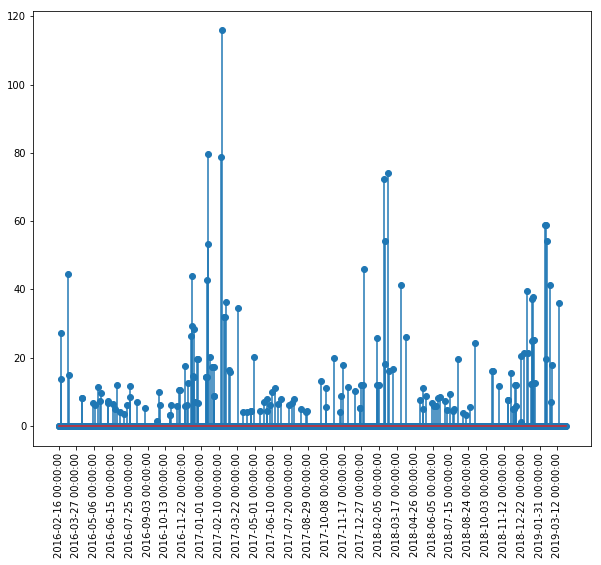

In [7]:
plt.figure(figsize = (10,8))
plt.stem(range(len(Precip)), Precip['precipitation'].values)
plt.xticks(np.arange(0,len(Precip), 40), Precip.loc[np.arange(0,len(Precip), 40),'date'].values , rotation = 90);

### waveforms

In [8]:
wave = pd.read_csv('radar_precipitation/waveforms.csv')

In [9]:
cluster1 = wave[wave['lat'] <= -24.35]
cluster2 = wave[(-24.35 < wave['lat']) & (wave['lat'] <= -24.25)]
cluster3 = wave[wave['lat']>=-24.25]

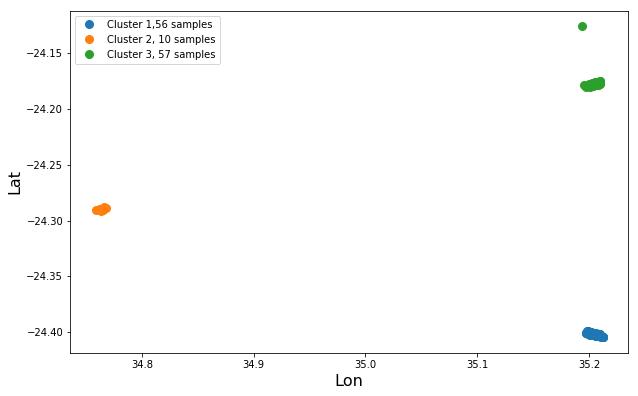

In [10]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.plot(cluster1['lon'].values, cluster1['lat'].values, 'o',  ms = 8, label = 'Cluster 1,{} samples'.format(len(cluster1)))
ax.plot(cluster2['lon'].values, cluster2['lat'].values, 'o',ms = 8, label = 'Cluster 2, {} samples'.format(len(cluster2)))
ax.plot(cluster3['lon'].values, cluster3['lat'].values, 'o',ms = 8, label = 'Cluster 3, {} samples'.format(len(cluster3)))

plt.legend(loc = 'upper left')

plt.xlabel('Lon', fontsize = 16)
plt.ylabel('Lat', fontsize = 16)
ax.set_aspect('equal')

### Cluster2 is where the crossover point is

In [11]:
cluster2 = cluster2.sort_values(by = ['time'])
cluster2 = cluster2.reset_index()

In [91]:
Precip2 = Precip.loc[cluster2['day'].values,'precipitation'].values

PrecipMA = (Precip['precipitation']).rolling(window=7, center = False).sum()

In [99]:
Precip_Previous7 = PrecipMA.loc[cluster2['day'].values].values
np.where(Precip_Previous7 >1)[0]

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


array([0, 1, 2, 3, 5, 6])

In [93]:
WaveForm2 = cluster2.loc[:, ['sample_{}'.format(a) for a in range(127)]]
Dates2 =[ datetime.strptime(cluster2.loc[a, 'time'], "%Y-%m-%d %H:%M:%S.%f").date() for a in range(10)]

<IPython.core.display.Javascript object>


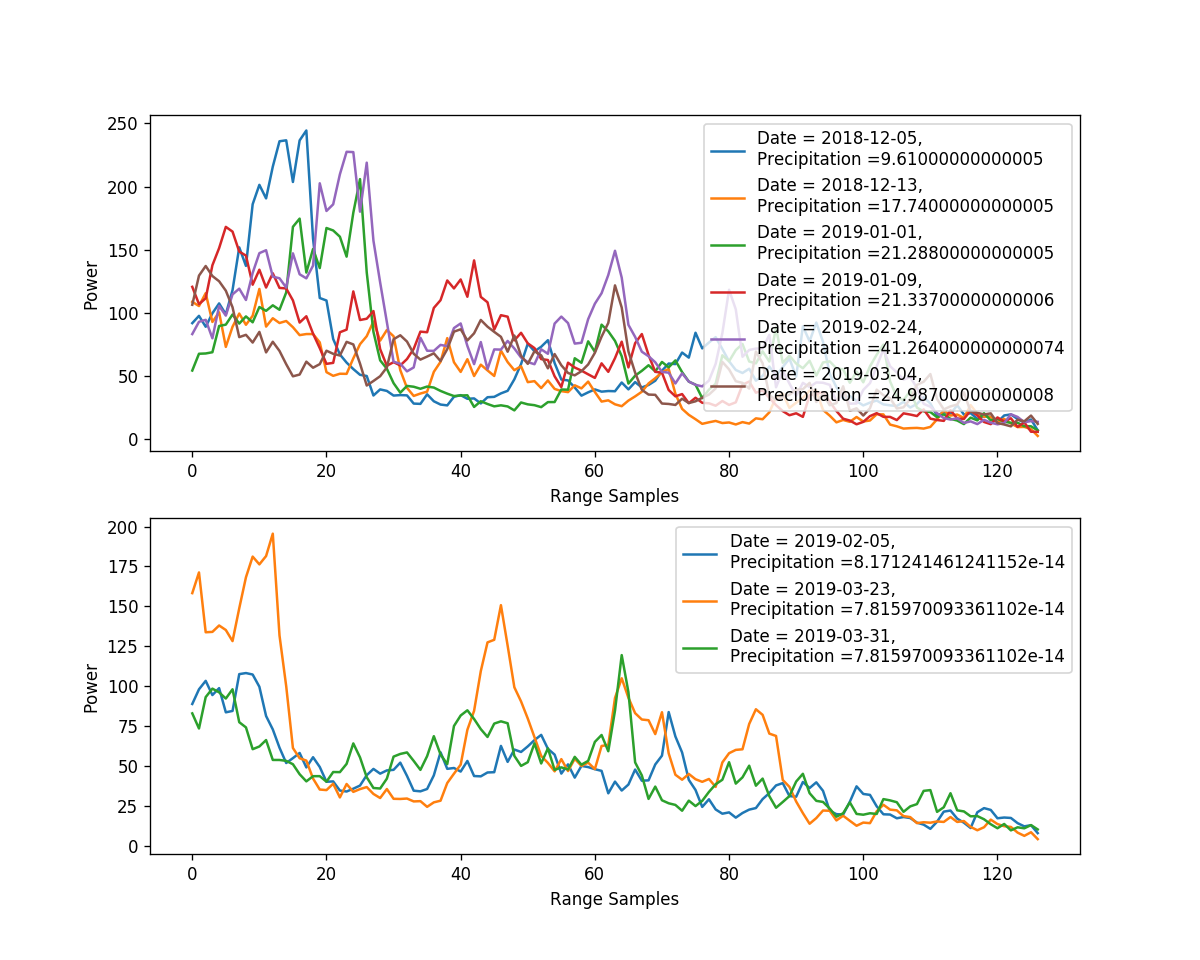

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


In [101]:
plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
for j in np.where(Precip_Previous7 >1)[0]:
    
    plt.plot(range(127), WaveForm2.loc[j,:].values, label = 'Date = {},\nPrecipitation ={}'.format(datetime.strptime(cluster2.loc[j, 'time'], "%Y-%m-%d %H:%M:%S.%f").date(), Precip_Previous7[j]))
plt.xlabel('Range Samples')
plt.ylabel('Power')
plt.legend(loc = 'upper right')

plt.subplot(2,1,2)
for j in np.where(Precip_Previous7 <1)[0]:
    
    plt.plot(range(127), WaveForm2.loc[j,:].values, label = 'Date = {},\nPrecipitation ={}'.format(datetime.strptime(cluster2.loc[j, 'time'], "%Y-%m-%d %H:%M:%S.%f").date(), Precip_Previous7[j]))
plt.xlabel('Range Samples')
plt.ylabel('Power')
plt.legend(loc = 'upper right')

In [47]:
window = 5
MA2 = WaveForm2.rolling(window=window, center = True, axis = 1).mean()

<IPython.core.display.Javascript object>


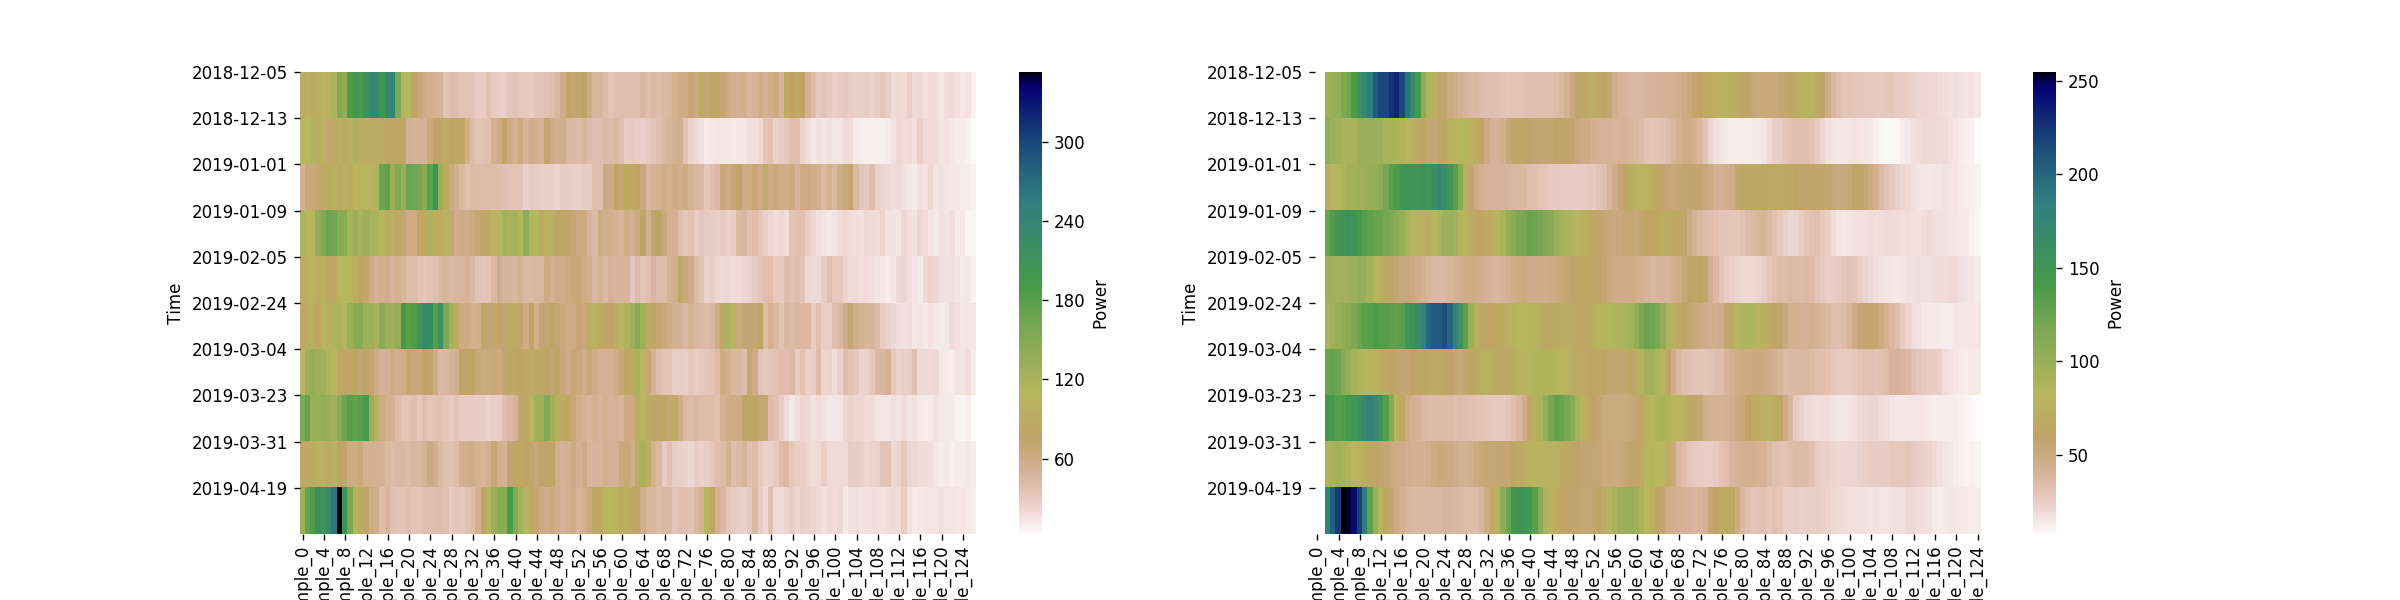

In [69]:
%matplotlib notebook
plt.figure(figsize = (20, 5))
plt.subplot(1,2,1)
sns.heatmap(WaveForm2,cmap = 'gist_earth_r', cbar_kws={'label': 'Power'})
plt.xlabel('Range Sample')
plt.ylabel('Time')
plt.yticks(range(10), Dates2, rotation = 0);

plt.subplot(1,2,2)
sns.heatmap(MA2, cmap = 'gist_earth_r', cbar_kws={'label': 'Power'})
plt.xlabel('Range Sample')
plt.ylabel('Time')
plt.yticks(range(10), Dates2, rotation = 0);


<IPython.core.display.Javascript object>


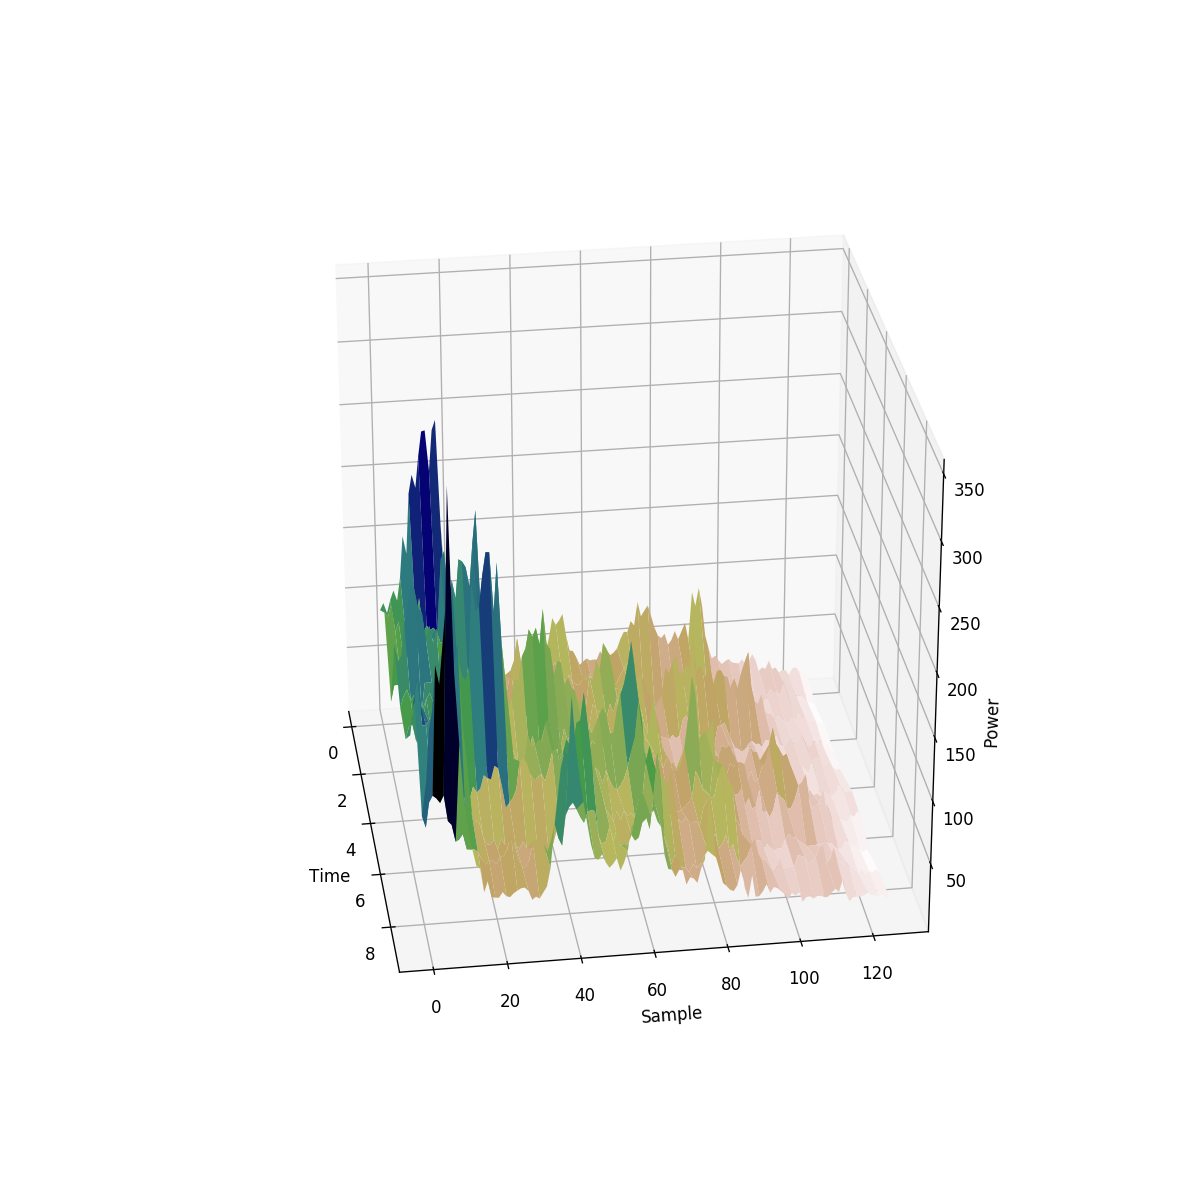

In [24]:
%matplotlib notebook
X =  WaveForm2.index
Y = range(len(WaveForm2.columns))
X, Y = np.meshgrid(X, Y)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
Z = WaveForm2.as_matrix()
ax.plot_surface(X, Y,Z.T,cmap = 'gist_earth_r', label = 'Power')
plt.xlabel('Time')
plt.ylabel('Sample')
ax.set_zlabel('Power')
plt.show()

In [17]:
cluster2['time']
# Precip['date']

0    2018-12-05 19:56:20.632342
1    2018-12-13 07:25:05.892468
2    2019-01-01 19:56:22.472501
3    2019-01-09 07:25:09.350459
4    2019-02-05 07:25:09.458407
5    2019-02-24 19:56:25.286113
6    2019-03-04 07:25:12.574116
7    2019-03-23 19:56:29.151410
8    2019-03-31 07:25:15.610574
9    2019-04-19 19:56:29.890484
Name: time, dtype: object

In [18]:
#reformat days

# convert dates to week ends
date_format = "%Y-%m-%d %H:%M:%S"

def Spacing(Dates):
    day = []
    earliestDate = min(Precip['date'])
    earliestDate = datetime.strptime(earliestDate, date_format)
    for i in range(0, len(Dates)):
        try:
            d = datetime.strptime(Dates[i], "%Y-%m-%d %H:%M:%S.%f")
        except ValueError:
            d = datetime.strptime(Dates[i], "%Y-%m-%d %H:%M:%S")
        day.append((d-earliestDate).days) 
    return day

In [19]:
Precip['day'] = Spacing(Precip['date'])

In [20]:
cluster2['day'] = Spacing(cluster2['time'])

### Scaled data

(array([  -60.,   -30.,     0.,    30.,    60.,    90.,   120.,   150.,
          180.,   210.,   240.,   270.,   300.,   330.,   360.,   390.,
          420.,   450.,   480.,   510.,   540.,   570.,   600.,   630.,
          660.,   690.,   720.,   750.,   780.,   810.,   840.,   870.,
          900.,   930.,   960.,   990.,  1020.,  1050.,  1080.,  1110.,
         1140.,  1170.,  1200.]), <a list of 43 Text xticklabel objects>)

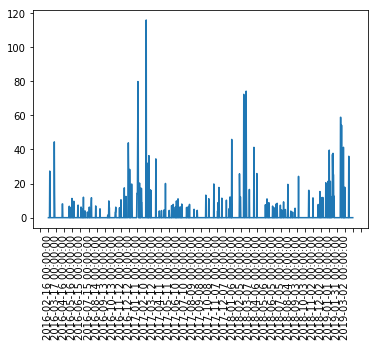

In [21]:
import matplotlib.ticker as ticker
tick_spacing = 30
fig, ax = plt.subplots(1,1)
ax.plot(Precip['date'].values, Precip['precipitation'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing),)
plt.xticks(rotation = 90)


In [29]:
len(Precip)

1140

<IPython.core.display.Javascript object>


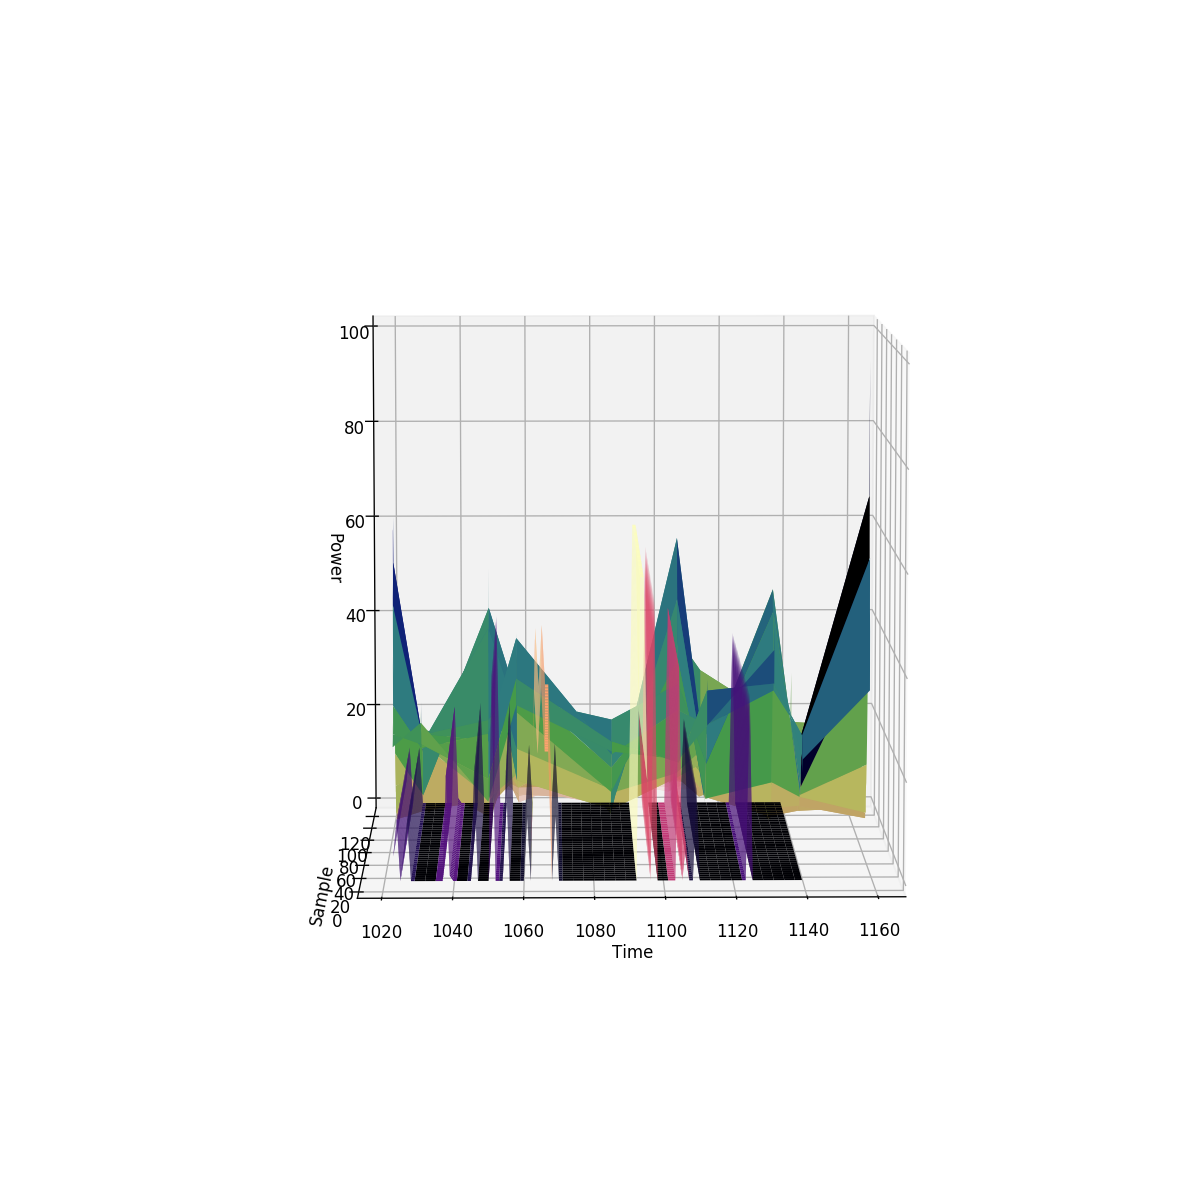

In [70]:
%matplotlib notebook
X_wave =  cluster2['day'].values
Y_wave = range(len(WaveForm2.columns))
X_wave, Y_wave = np.meshgrid(X_wave, Y_wave)
Y_precip =range(len(WaveForm2.columns))
X_precip = range(1023,1140)
# Precip['day'].values
X_precip, Y_precip = np.meshgrid(X_precip, Y_precip)

Z_precip = np.matrix([Precip.loc[1023:1140, 'precipitation'].values,]*len(WaveForm2.columns))
Z_wave = (WaveForm2.as_matrix()/(WaveForm2.as_matrix()).max())*100


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_wave, Y_wave,Z_wave.T,cmap = 'gist_earth_r', label = 'Power')
ax.plot_surface(X_precip, Y_precip,Z_precip,cmap = 'magma')

plt.xlabel('Time')
plt.ylabel('Sample')
ax.set_zlabel('Power')
plt.show()